In [22]:
# Celda 1: Imports para BERT y SHAP
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import json
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import os
import pickle
import warnings
warnings.filterwarnings('ignore')

In [23]:
# Celda 2: Carga de datasets y configuración BERT
# Cargar datasets
df_codigos = pd.read_csv(r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\TFG\dataset\diagnosticos_binarios_codigos.csv", on_bad_lines='skip', delimiter='|')
df_descr = pd.read_csv(r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\TFG\dataset\diagnosticos_binarios_descripciones.csv", on_bad_lines='skip', delimiter='|')
df_comb = pd.read_csv(r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\TFG\dataset\diagnosticos_binarios_combinados.csv", on_bad_lines='skip', delimiter='|')

datasets = {
    "codigos": df_codigos,
    "descripciones": df_descr,
    "combinado": df_comb
}

# Configuración de modelos BERT (ajusta las rutas según tus modelos)
bert_models = {
    "codigos": {
        "model_path": r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\models\dccuchile_bert-base-spanish-wwm-cased_codigos_final",
        "tokenizer_path": r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\models\dccuchile_bert-base-spanish-wwm-cased_codigos_final"
    },
    "descripciones": {
        "model_path": r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\models\dccuchile_bert-base-spanish-wwm-uncased_descripciones_final", 
        "tokenizer_path": r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\models\dccuchile_bert-base-spanish-wwm-uncased_descripciones_final"
    },
    "combinado": {
        "model_path": r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\models\dccuchile_bert-base-spanish-wwm-cased_combinado_final",
        "tokenizer_path": r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\models\dccuchile_bert-base-spanish-wwm-cased_combinado_final"
    }
}

print("✅ Datasets y configuración BERT cargados exitosamente")
print(f"📊 Datasets disponibles: {list(datasets.keys())}")
print(f"🤖 Modelos BERT configurados: {list(bert_models.keys())}")

✅ Datasets y configuración BERT cargados exitosamente
📊 Datasets disponibles: ['codigos', 'descripciones', 'combinado']
🤖 Modelos BERT configurados: ['codigos', 'descripciones', 'combinado']


In [24]:
# Celda 3: Clase wrapper para BERT compatible con SHAP
class BERTWrapper:
    def __init__(self, model_path, tokenizer_path, max_length=512):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_path)
        self.model.to(self.device)
        self.model.eval()
        self.max_length = max_length
        
    def predict_proba(self, texts):
        """Función requerida por SHAP para obtener probabilidades"""
        if isinstance(texts, str):
            texts = [texts]
        elif isinstance(texts, np.ndarray):
            texts = texts.tolist()
        
        probabilities = []
        
        with torch.no_grad():
            for text in texts:
                # Tokenizar
                inputs = self.tokenizer(
                    str(text),
                    max_length=self.max_length,
                    truncation=True,
                    padding='max_length',
                    return_tensors='pt'
                )
                
                # Mover a GPU si está disponible
                inputs = {k: v.to(self.device) for k, v in inputs.items()}
                
                # Predicción
                outputs = self.model(**inputs)
                logits = outputs.logits
                
                # Convertir a probabilidades
                probs = torch.softmax(logits, dim=-1)
                probabilities.append(probs.cpu().numpy()[0])
        
        return np.array(probabilities)
    
    def predict(self, texts):
        """Función para obtener predicciones (clase más probable)"""
        probas = self.predict_proba(texts)
        return np.argmax(probas, axis=1)

print("✅ Clase BERTWrapper definida")

✅ Clase BERTWrapper definida


In [25]:
# Celda 4: Función para analizar modelo BERT con SHAP (CORREGIDA FINAL)
def analizar_bert_shap(df, nombre_dataset, bert_config):
    print(f"\n📌 Analizando BERT en dataset: {nombre_dataset}")
    print(f"🔧 Modelo: {bert_config['model_path']}")
    
    # Crear directorio para guardar gráficas
    output_dir = f"shap_plots_bert/{nombre_dataset}_BERT"
    os.makedirs(output_dir, exist_ok=True)
    
    # Preparar datos
    # Combinar todas las columnas excepto la de la etiqueta en un solo texto
    text_columns = [col for col in df.columns if col != 'DIAG PSQ']
    X = df[text_columns].fillna('').astype(str).agg(' '.join, axis=1)
    
    # Preparar la variable objetivo según el dataset
    if nombre_dataset == "codigos":
        y = df['DIAG PSQ'].apply(lambda x: 1 if "F20" in str(x) and "F20.89" not in str(x) else 0)
    elif nombre_dataset == "descripciones":
        y = df['DIAG PSQ'].apply(lambda x: 1 if "Esquizofrenia" in str(x) and "Otros tipos de esquizofrenia" not in str(x) else 0)
    else:  # combinado
        y = df['DIAG PSQ'].apply(lambda x: 1 if "F20.89" in str(x) else 0)
    
    print(f"📈 Distribución de clases: {y.value_counts().to_dict()}")
    
    # División de datos
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    
    try:
        # Cargar modelo BERT
        print("🤖 Cargando modelo BERT...")
        bert_model = BERTWrapper(
            bert_config['model_path'], 
            bert_config['tokenizer_path']
        )
        
        # Calcular accuracy en conjunto de prueba (muestra pequeña para eficiencia)
        test_sample = X_test.head(100)
        y_test_sample = y_test.head(100)
        predictions = bert_model.predict(test_sample.tolist())
        accuracy = np.mean(predictions == y_test_sample)
        print(f"✅ Accuracy del modelo BERT: {accuracy:.4f}")
        
        # SHAP analysis
        print("🔎 Generando explicaciones SHAP para BERT...")
        
        # Usar una muestra pequeña para SHAP (es computacionalmente costoso)
        n_samples = min(3, len(X_test))  # Reducir a 3 muestras
        X_shap = X_test.head(n_samples).tolist()
        
        # Crear explainer
        print("🔧 Creando SHAP explainer...")
        explainer = shap.Explainer(bert_model.predict_proba, shap.maskers.Text(bert_model.tokenizer))
        
        # Calcular valores SHAP (esto puede tomar tiempo)
        print("⏳ Calculando valores SHAP (esto puede tomar varios minutos)...")
        shap_values = explainer(X_shap)
        
        print(f"📊 SHAP values calculados: {len(shap_values)} muestras")
        print(f"📊 SHAP values shape: {shap_values.values.shape}")
        print(f"📊 Base values shape: {shap_values.base_values.shape}")
        print(f"📊 Data shape: {len(shap_values.data)}")
        
        # 1. Text plot para las primeras 3 muestras
        print("📝 Generando text plots...")
        for i in range(min(3, len(shap_values))):
            try:
                plt.figure(figsize=(15, 8))
                
                # Crear explanation individual para cada muestra
                if shap_values.values.ndim == 3 and shap_values.values.shape[-1] == 2:
                    # Para clasificación binaria, usar la clase positiva (índice 1)
                    sample_values = shap_values.values[i]  # Shape: (n_tokens, 2)
                    if sample_values.ndim == 2 and sample_values.shape[1] == 2:
                        values_pos = sample_values[:, 1]  # Solo clase positiva
                    else:
                        values_pos = sample_values
                    
                    base_val = shap_values.base_values[i, 1] if shap_values.base_values.ndim > 1 else shap_values.base_values[i]
                    
                    explanation_pos = shap.Explanation(
                        values=values_pos,
                        base_values=base_val,
                        data=shap_values.data[i]
                    )
                    shap.plots.text(explanation_pos, display=False)
                else:
                    shap.plots.text(shap_values[i], display=False)
                
                plt.title(f'SHAP Text Plot - BERT ({nombre_dataset}) - Muestra {i+1}', 
                         fontsize=14, fontweight='bold')
                plt.tight_layout()
                plt.savefig(f"{output_dir}/text_plot_sample_{i+1}.png", dpi=300, bbox_inches='tight')
                plt.show()
                print(f"💾 Text plot muestra {i+1} guardado en: {output_dir}/text_plot_sample_{i+1}.png")
            except Exception as e:
                print(f"⚠️  Error generando text plot {i+1}: {e}")
                print(f"Debug - Valores shape: {shap_values.values[i].shape}")
        
        # 2. Waterfall plot para las primeras 3 muestras
        print("🌊 Generando Waterfall plots...")
        for i in range(min(3, len(shap_values))):
            try:
                plt.figure(figsize=(12, 8))
                
                # Crear explanation individual para cada muestra
                if shap_values.values.ndim == 3 and shap_values.values.shape[-1] == 2:
                    # Para clasificación binaria, usar la clase positiva (índice 1)
                    sample_values = shap_values.values[i]  # Shape: (n_tokens, 2)
                    if sample_values.ndim == 2 and sample_values.shape[1] == 2:
                        values_pos = sample_values[:, 1]  # Solo clase positiva
                    else:
                        values_pos = sample_values
                    
                    base_val = shap_values.base_values[i, 1] if shap_values.base_values.ndim > 1 else shap_values.base_values[i]
                    
                    explanation_pos = shap.Explanation(
                        values=values_pos,
                        base_values=base_val,
                        data=shap_values.data[i]
                    )
                    shap.plots.waterfall(explanation_pos, max_display=20, show=False)
                else:
                    shap.plots.waterfall(shap_values[i], max_display=20, show=False)
                
                plt.title(f'Waterfall Plot - BERT ({nombre_dataset}) - Muestra {i+1}', 
                         fontsize=14, fontweight='bold')
                plt.tight_layout()
                plt.savefig(f"{output_dir}/waterfall_sample_{i+1}.png", dpi=300, bbox_inches='tight')
                plt.show()
                print(f"💾 Waterfall plot muestra {i+1} guardado en: {output_dir}/waterfall_sample_{i+1}.png")
            except Exception as e:
                print(f"⚠️  Error generando waterfall plot {i+1}: {e}")
                print(f"Debug - Sample values shape: {shap_values.values[i].shape}")
        
        # 3. Bar plot de importancia promedio (método manual mejorado)
        print("📊 Generando bar plot de importancia...")
        try:
            plt.figure(figsize=(12, 8))
            
            # Recopilar todas las importancias de todas las muestras
            all_token_importances = {}
            
            for i in range(len(shap_values)):
                sample_values = shap_values.values[i]
                sample_data = shap_values.data[i]
                
                # Extraer valores para la clase positiva si es clasificación binaria
                if sample_values.ndim == 2 and sample_values.shape[1] == 2:
                    values_to_use = sample_values[:, 1]  # Clase positiva
                else:
                    values_to_use = sample_values
                
                # Asociar cada token con su importancia
                for j, token in enumerate(sample_data):
                    if j < len(values_to_use):
                        token_str = str(token)
                        if token_str not in all_token_importances:
                            all_token_importances[token_str] = []
                        all_token_importances[token_str].append(abs(values_to_use[j]))
            
            # Calcular importancia promedio por token
            token_avg_importance = {}
            for token, importances in all_token_importances.items():
                token_avg_importance[token] = np.mean(importances)
            
            # Obtener los top tokens
            if token_avg_importance:
                sorted_tokens = sorted(token_avg_importance.items(), key=lambda x: x[1], reverse=True)
                top_tokens = sorted_tokens[:20]  # Top 20
                
                if top_tokens:
                    tokens, importances = zip(*top_tokens)
                    
                    plt.barh(range(len(tokens)), importances)
                    plt.yticks(range(len(tokens)), tokens)
                    plt.xlabel('Mean |SHAP Value|')
                    plt.title(f'Token Importance - BERT ({nombre_dataset})', fontsize=14, fontweight='bold')
                    plt.tight_layout()
                    plt.savefig(f"{output_dir}/feature_importance.png", dpi=300, bbox_inches='tight')
                    plt.show()
                    print(f"💾 Feature importance guardado en: {output_dir}/feature_importance.png")
                else:
                    print("⚠️  No se encontraron tokens con importancia")
            else:
                print("⚠️  No se pudo calcular importancia de tokens")
            
        except Exception as e:
            print(f"⚠️  Error generando bar plot: {e}")
            import traceback
            print(f"Traceback: {traceback.format_exc()}")
        
        return bert_model, accuracy
        
    except Exception as e:
        print(f"❌ Error analizando BERT: {e}")
        print(f"Tipo de error: {type(e).__name__}")
        import traceback
        print(f"Detalles del error:\n{traceback.format_exc()}")
        return None, 0.0

print("✅ Función de análisis BERT-SHAP definida (CORREGIDA FINAL)")

✅ Función de análisis BERT-SHAP definida (CORREGIDA FINAL)



🎯 PROCESANDO DATASET BERT: CODIGOS

📌 Analizando BERT en dataset: codigos
🔧 Modelo: C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\models\dccuchile_bert-base-spanish-wwm-cased_codigos_final
📈 Distribución de clases: {0: 1385, 1: 612}
🤖 Cargando modelo BERT...
✅ Accuracy del modelo BERT: 0.7600
🔎 Generando explicaciones SHAP para BERT...
🔧 Creando SHAP explainer...
⏳ Calculando valores SHAP (esto puede tomar varios minutos)...


PartitionExplainer explainer: 4it [00:31, 10.39s/it]                       


📊 SHAP values calculados: 3 muestras
📊 SHAP values shape: (3,)
📊 Base values shape: (3, 2)
📊 Data shape: 3
📝 Generando text plots...


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

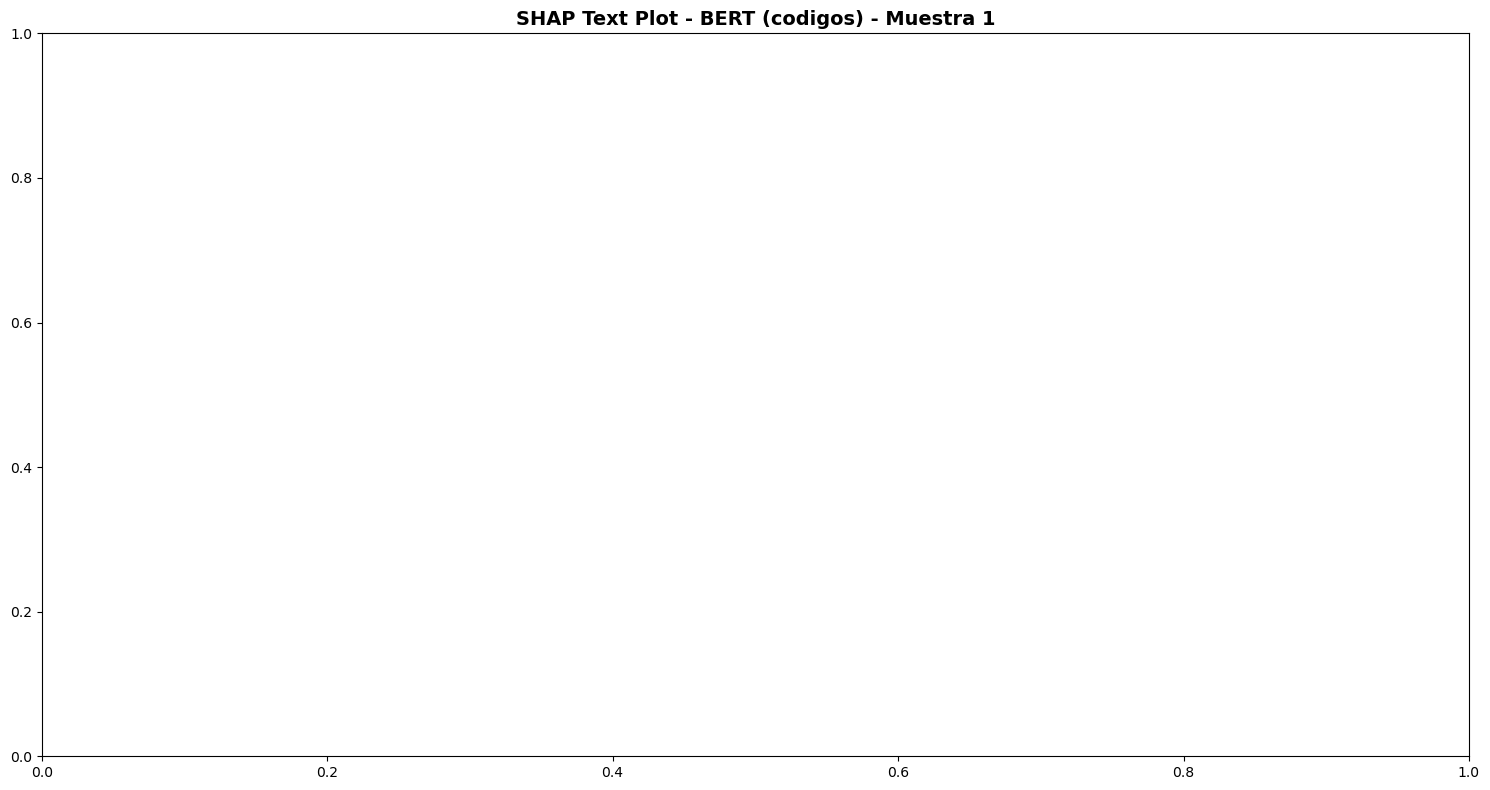

💾 Text plot muestra 1 guardado en: shap_plots_bert/codigos_BERT/text_plot_sample_1.png


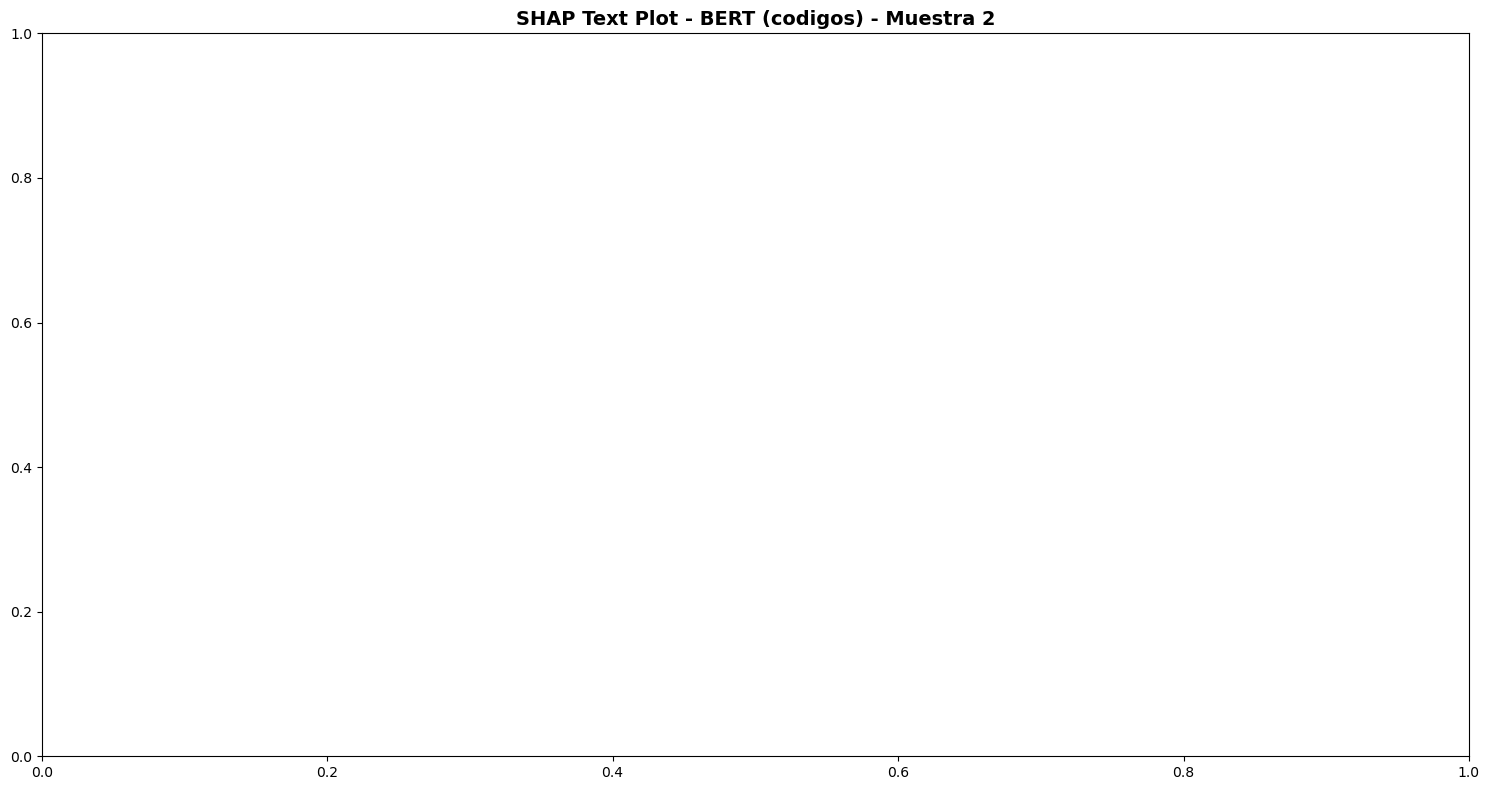

💾 Text plot muestra 2 guardado en: shap_plots_bert/codigos_BERT/text_plot_sample_2.png


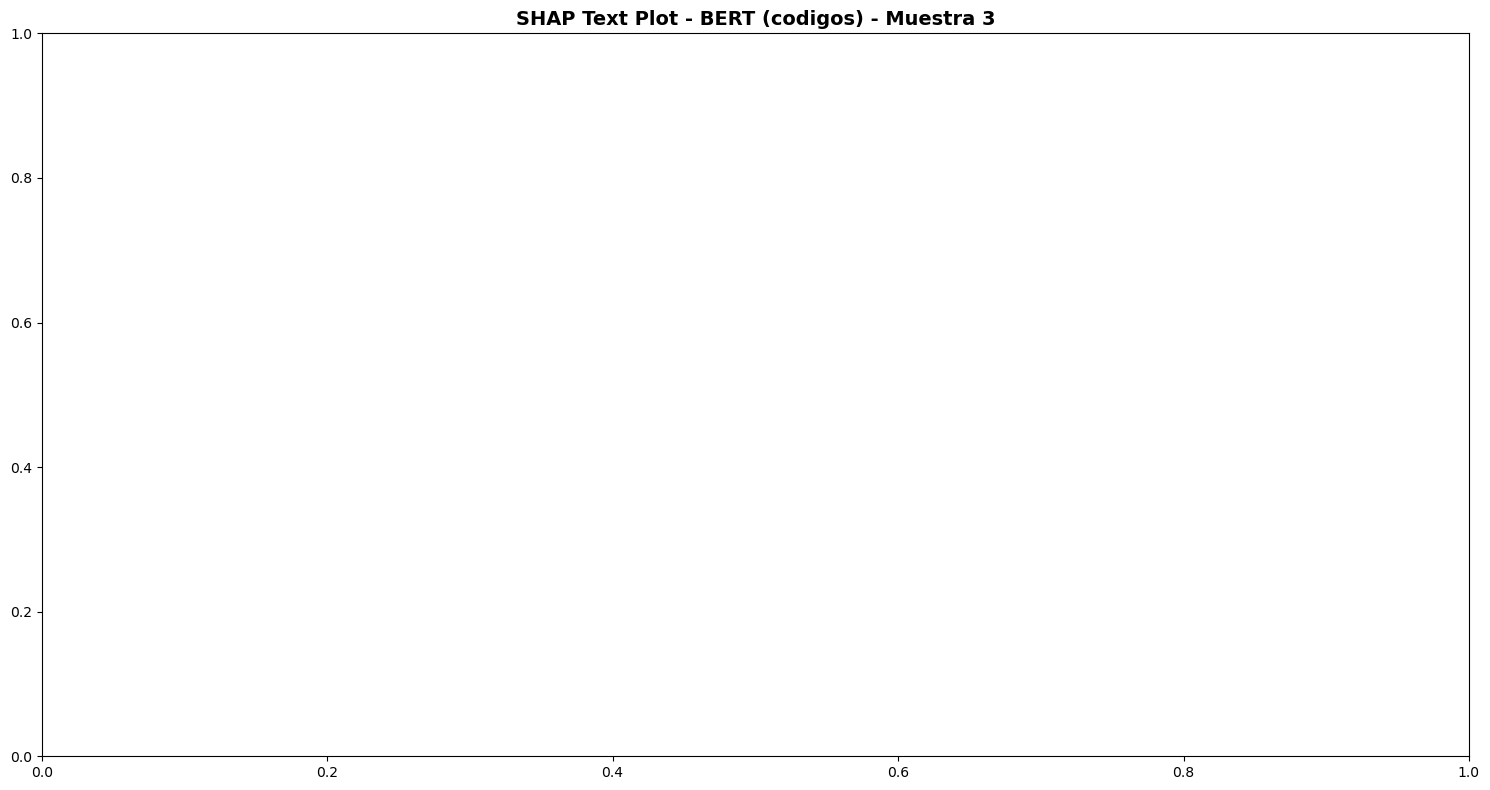

💾 Text plot muestra 3 guardado en: shap_plots_bert/codigos_BERT/text_plot_sample_3.png
🌊 Generando Waterfall plots...
⚠️  Error generando waterfall plot 1: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (22, 2)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.
Debug - Sample values shape: (22, 2)
⚠️  Error generando waterfall plot 2: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (15, 2)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.
Debug - Sample values shape: (15, 2)
⚠️  Error generando waterfall plot 3: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (40, 2)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output model

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

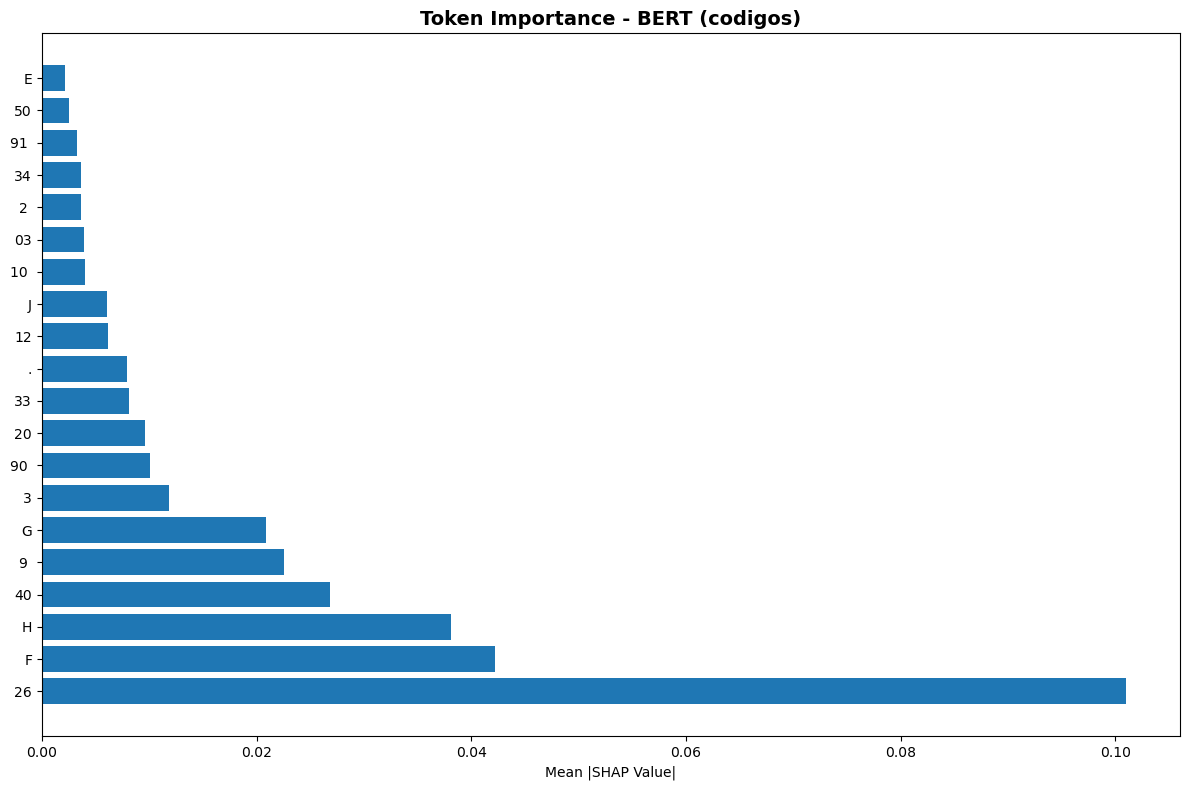

💾 Feature importance guardado en: shap_plots_bert/codigos_BERT/feature_importance.png

🎯 PROCESANDO DATASET BERT: DESCRIPCIONES

📌 Analizando BERT en dataset: descripciones
🔧 Modelo: C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\models\dccuchile_bert-base-spanish-wwm-uncased_descripciones_final
📈 Distribución de clases: {0: 1394, 1: 603}
🤖 Cargando modelo BERT...
✅ Accuracy del modelo BERT: 0.9100
🔎 Generando explicaciones SHAP para BERT...
🔧 Creando SHAP explainer...
⏳ Calculando valores SHAP (esto puede tomar varios minutos)...


PartitionExplainer explainer: 4it [00:40, 13.43s/it]                       


📊 SHAP values calculados: 3 muestras
📊 SHAP values shape: (3,)
📊 Base values shape: (3, 2)
📊 Data shape: 3
📝 Generando text plots...


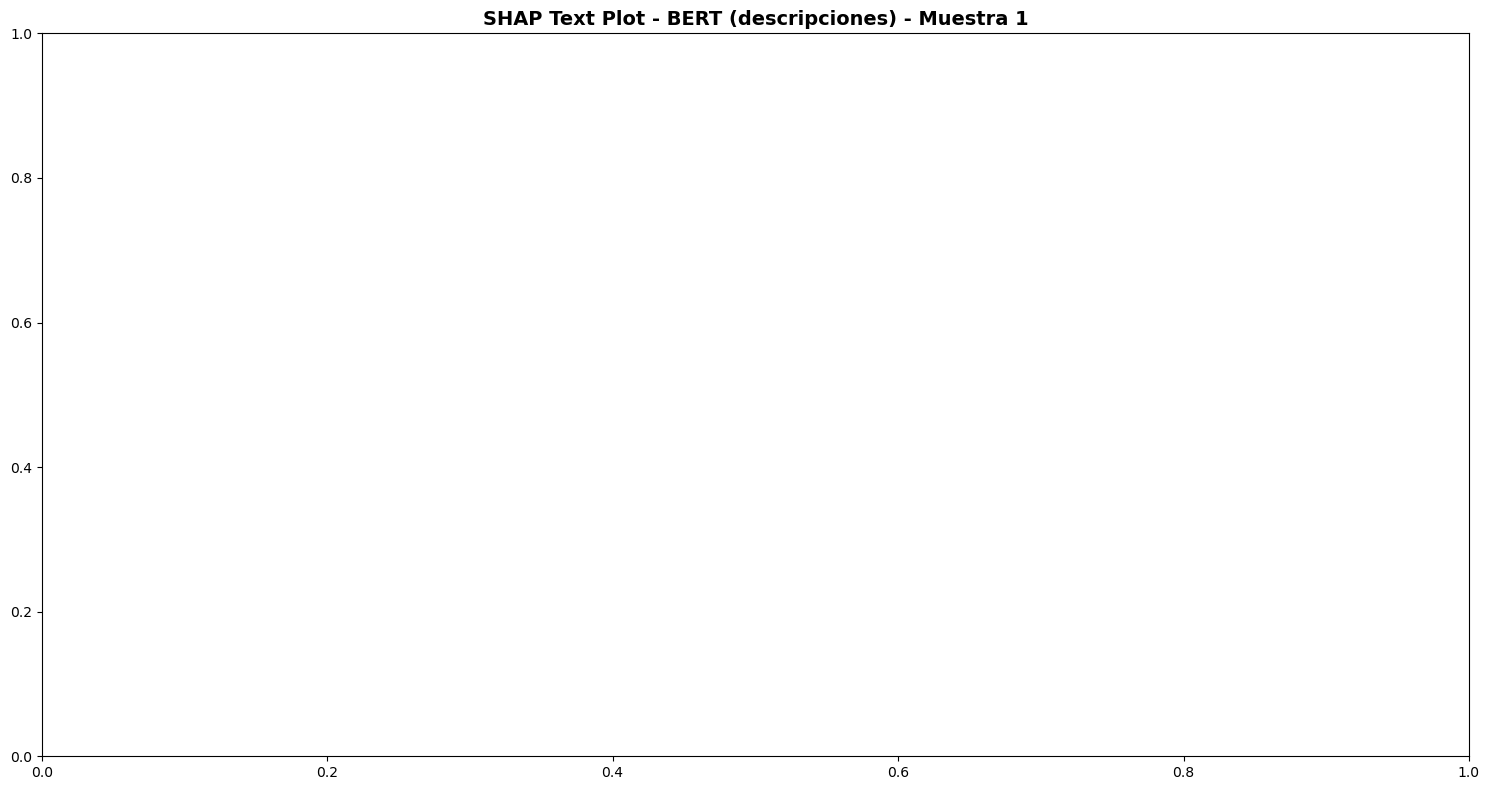

💾 Text plot muestra 1 guardado en: shap_plots_bert/descripciones_BERT/text_plot_sample_1.png


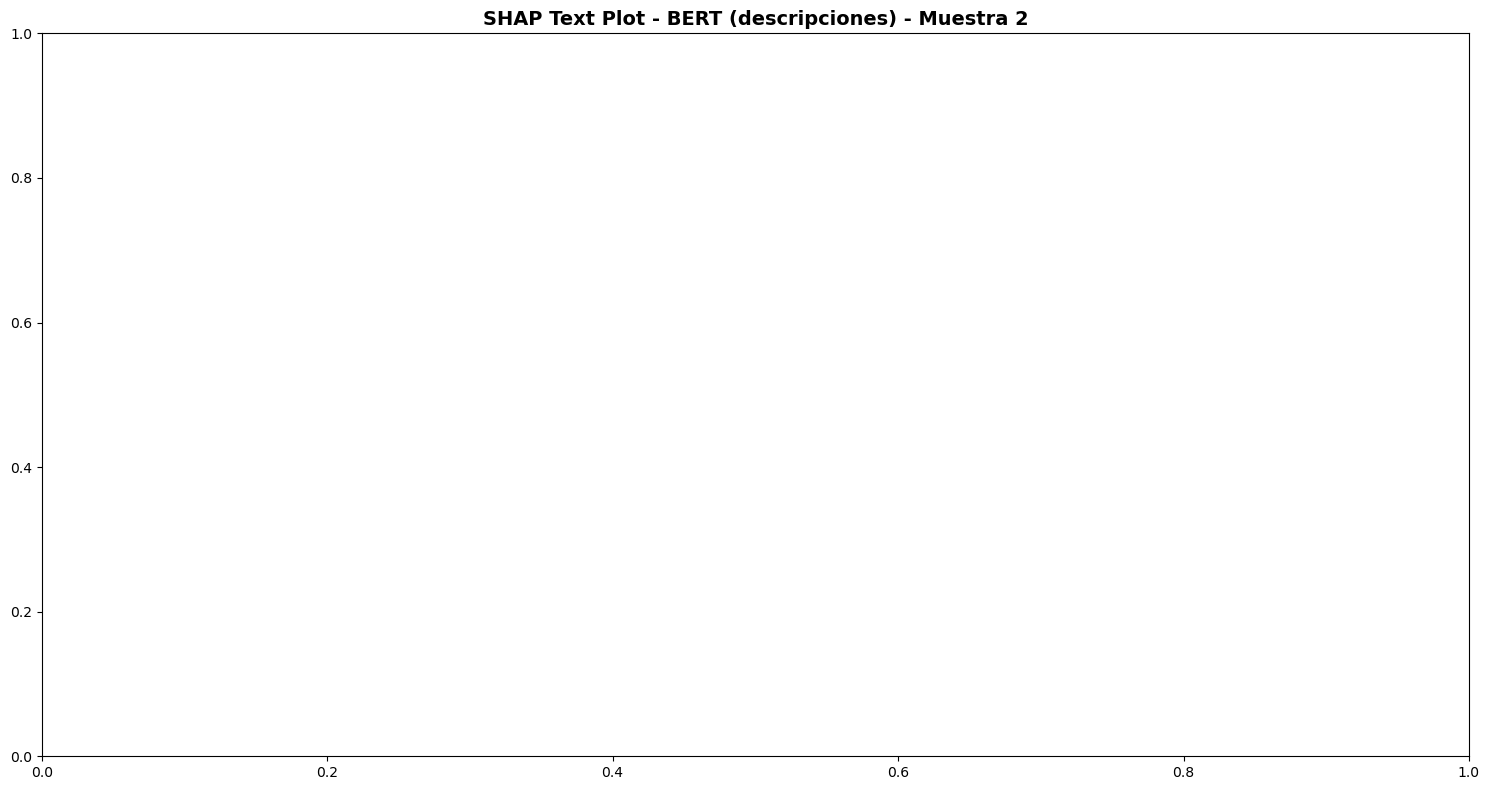

💾 Text plot muestra 2 guardado en: shap_plots_bert/descripciones_BERT/text_plot_sample_2.png


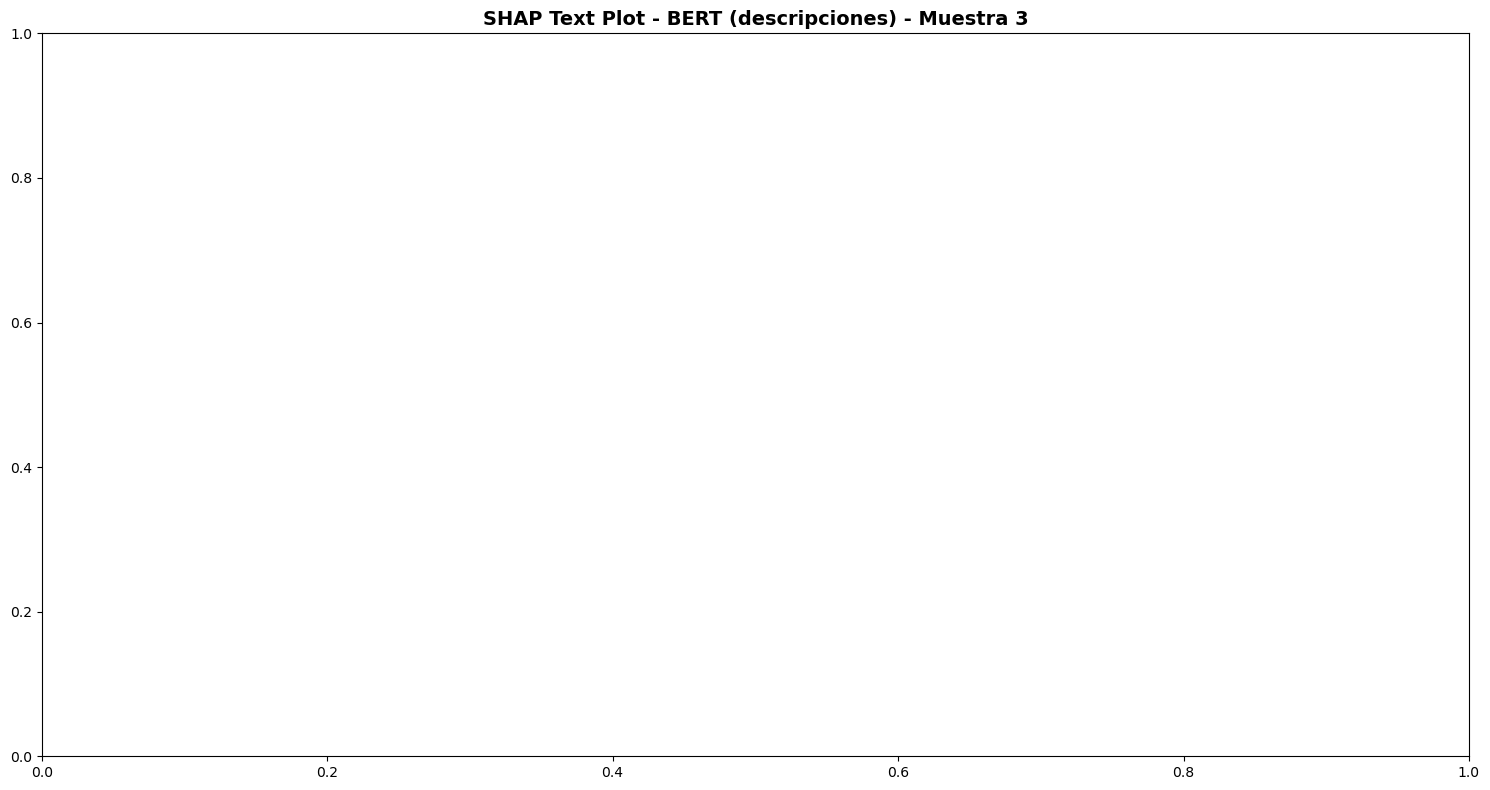

💾 Text plot muestra 3 guardado en: shap_plots_bert/descripciones_BERT/text_plot_sample_3.png
🌊 Generando Waterfall plots...
⚠️  Error generando waterfall plot 1: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (95, 2)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.
Debug - Sample values shape: (95, 2)
⚠️  Error generando waterfall plot 2: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (111, 2)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.
Debug - Sample values shape: (111, 2)
⚠️  Error generando waterfall plot 3: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (22, 2)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-outp

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

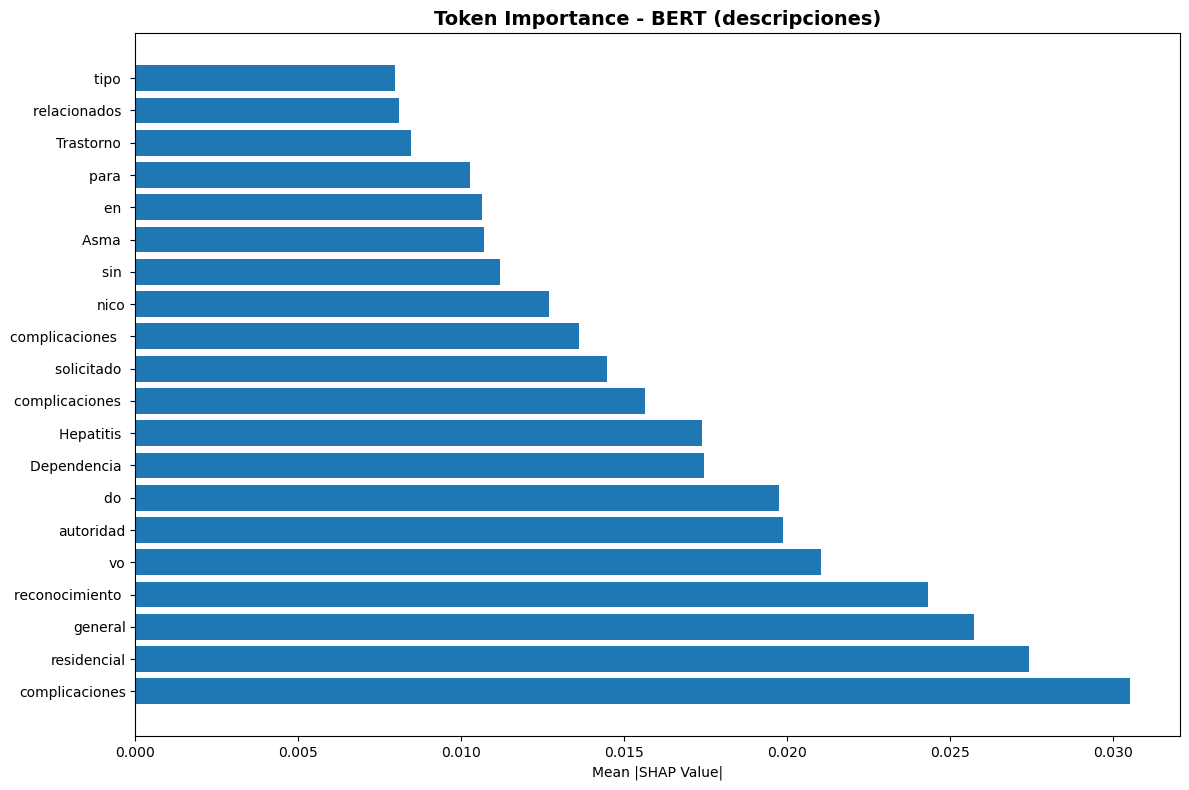

💾 Feature importance guardado en: shap_plots_bert/descripciones_BERT/feature_importance.png

🎯 PROCESANDO DATASET BERT: COMBINADO

📌 Analizando BERT en dataset: combinado
🔧 Modelo: C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\models\dccuchile_bert-base-spanish-wwm-cased_combinado_final
📈 Distribución de clases: {1: 1385, 0: 612}
🤖 Cargando modelo BERT...
✅ Accuracy del modelo BERT: 0.1200
🔎 Generando explicaciones SHAP para BERT...
🔧 Creando SHAP explainer...
⏳ Calculando valores SHAP (esto puede tomar varios minutos)...


PartitionExplainer explainer: 4it [00:39, 13.01s/it]                       


📊 SHAP values calculados: 3 muestras
📊 SHAP values shape: (3,)
📊 Base values shape: (3, 2)
📊 Data shape: 3
📝 Generando text plots...


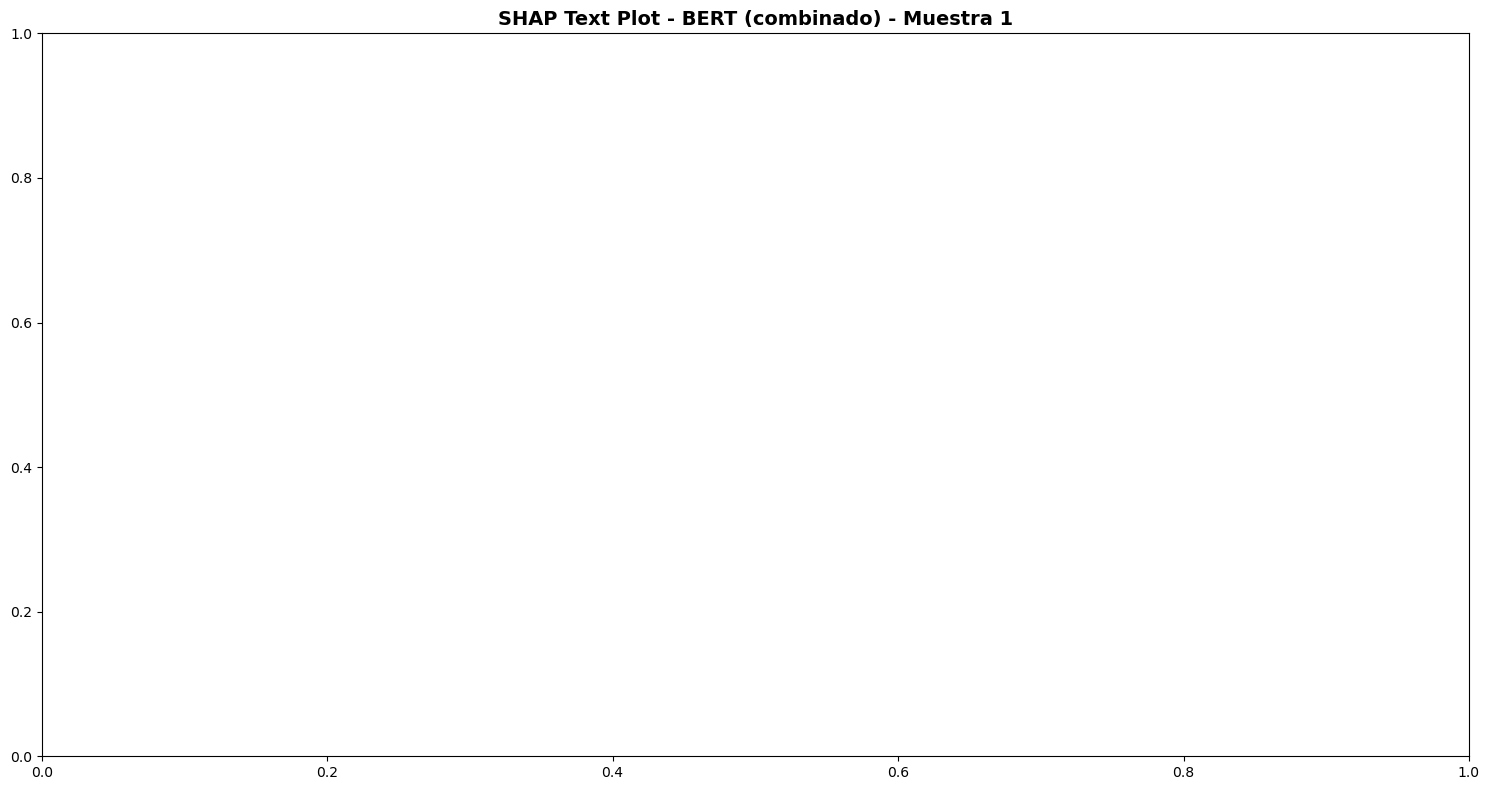

💾 Text plot muestra 1 guardado en: shap_plots_bert/combinado_BERT/text_plot_sample_1.png


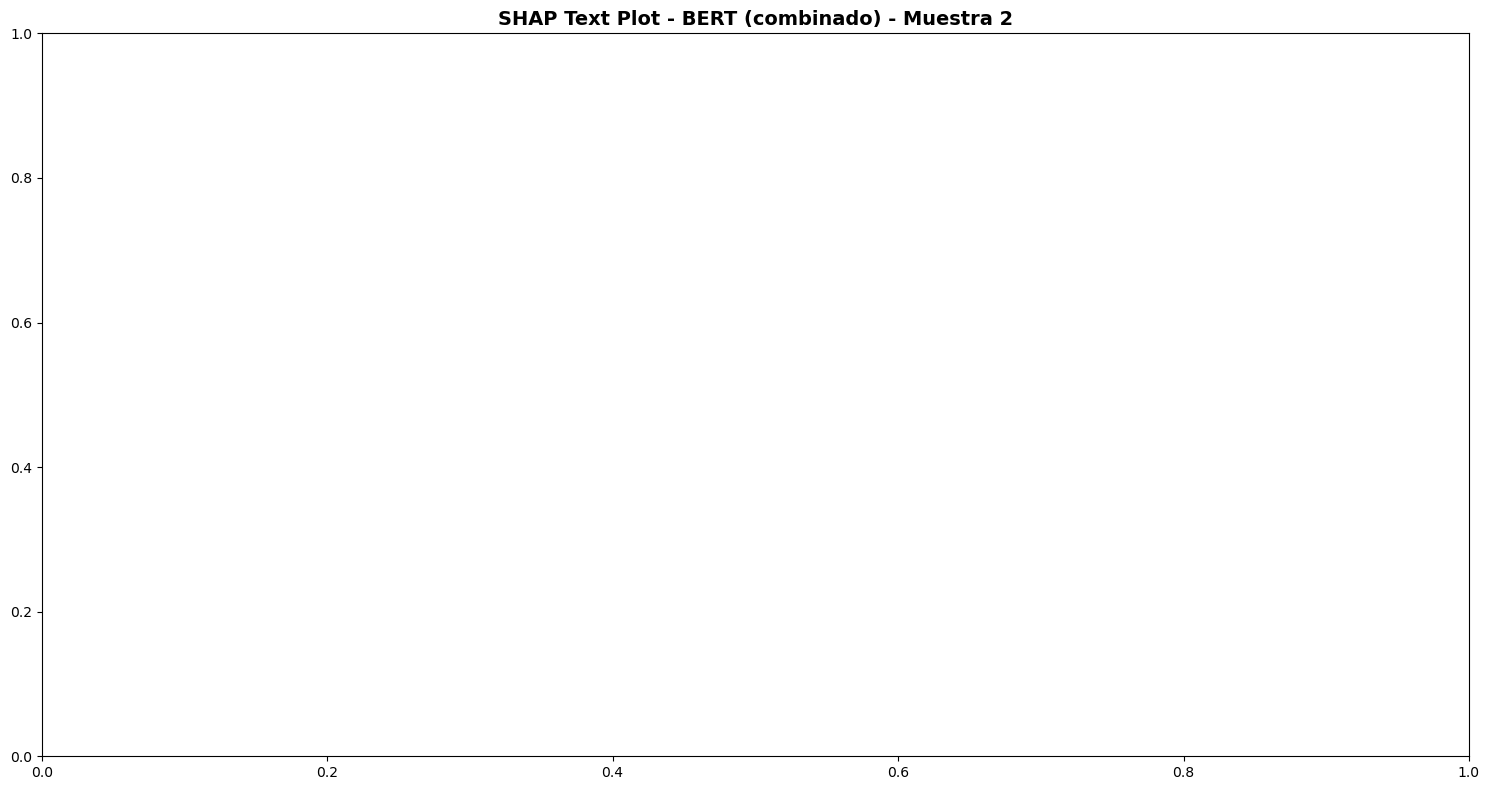

💾 Text plot muestra 2 guardado en: shap_plots_bert/combinado_BERT/text_plot_sample_2.png


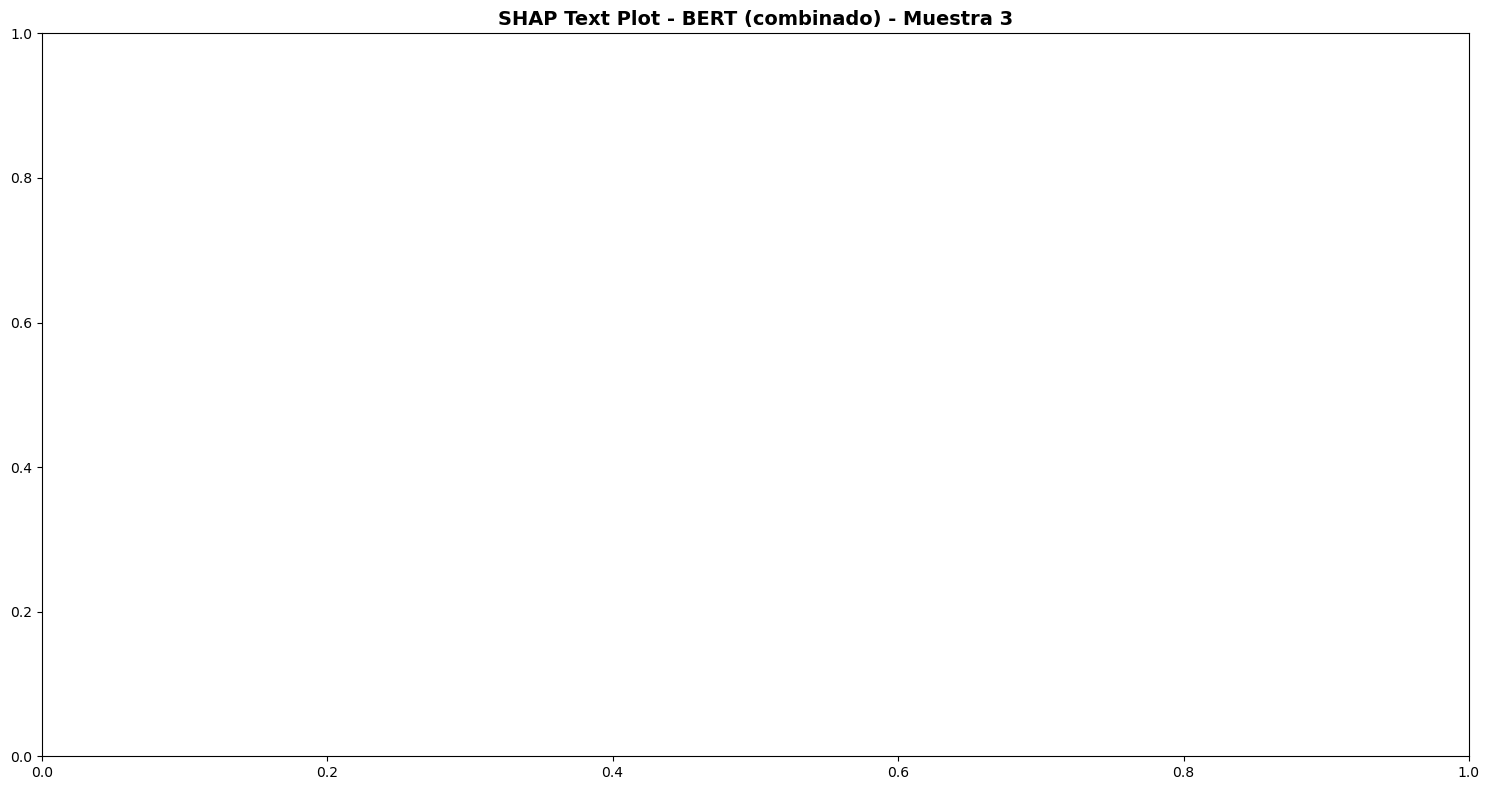

💾 Text plot muestra 3 guardado en: shap_plots_bert/combinado_BERT/text_plot_sample_3.png
🌊 Generando Waterfall plots...
⚠️  Error generando waterfall plot 1: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (74, 2)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.
Debug - Sample values shape: (74, 2)
⚠️  Error generando waterfall plot 2: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (49, 2)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.
Debug - Sample values shape: (49, 2)
⚠️  Error generando waterfall plot 3: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (106, 2)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output mo

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

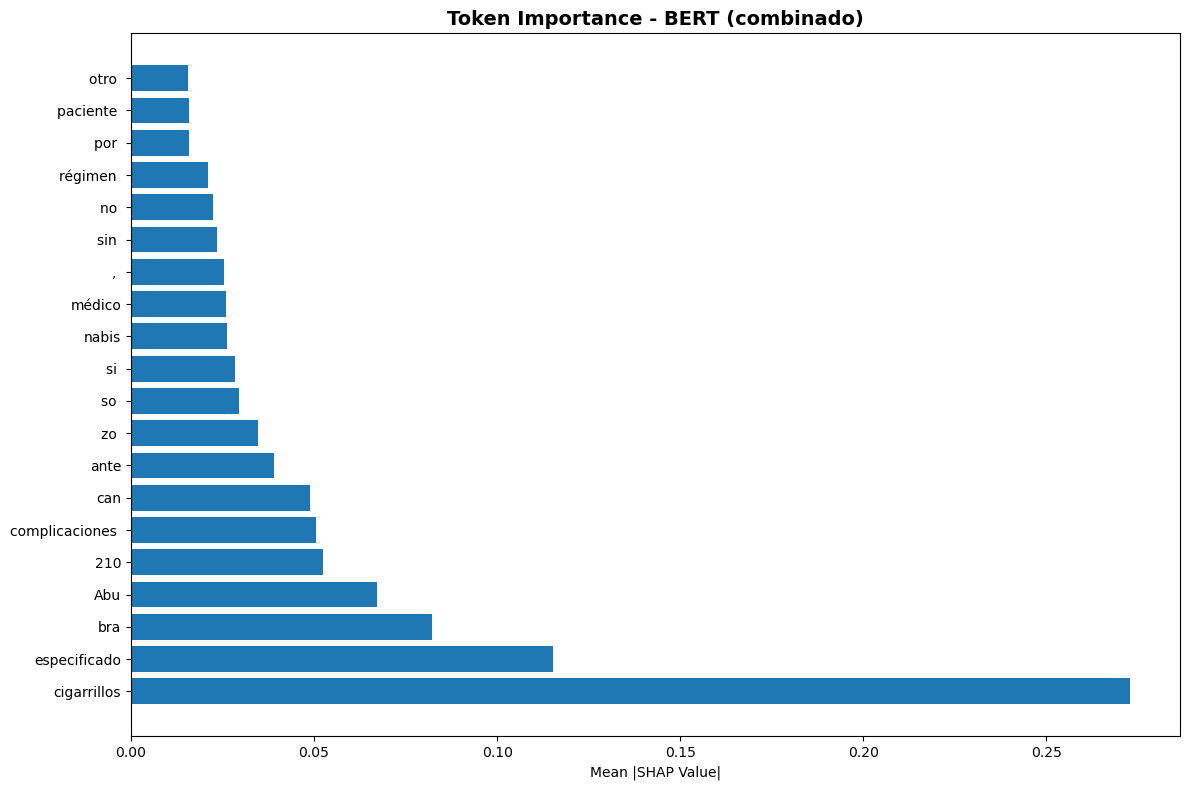

💾 Feature importance guardado en: shap_plots_bert/combinado_BERT/feature_importance.png

🎉 Análisis SHAP-BERT completado!


In [26]:
# Celda 5: Análisis SHAP para todos los modelos BERT
results_bert = {}

# Iterar sobre datasets
for dataset_name, df in datasets.items():
    print(f"\n{'='*60}")
    print(f"🎯 PROCESANDO DATASET BERT: {dataset_name.upper()}")
    print(f"{'='*60}")
    
    if dataset_name in bert_models:
        try:
            # Analizar modelo BERT
            model, accuracy = analizar_bert_shap(
                df, dataset_name, bert_models[dataset_name]
            )
            
            # Guardar resultados
            results_bert[dataset_name] = {
                "model": model,
                "accuracy": accuracy,
                "model_path": bert_models[dataset_name]['model_path']
            }
            
        except Exception as e:
            print(f"❌ Error procesando BERT en {dataset_name}: {e}")
            results_bert[dataset_name] = {
                "model": None,
                "accuracy": 0.0,
                "error": str(e)
            }
    else:
        print(f"❌ No se encontró configuración BERT para {dataset_name}")

print(f"\n🎉 Análisis SHAP-BERT completado!")

In [27]:
# Celda 6: Resumen de resultados BERT
print("\n📊 RESUMEN DE RESULTADOS BERT")
print("=" * 80)

for dataset_name, result in results_bert.items():
    print(f"\n🎯 Dataset: {dataset_name.upper()}")
    print("-" * 40)
    
    if result["model"] is not None:
        print(f"✅ BERT: Accuracy = {result['accuracy']:.4f}")
        print(f"📁 Modelo: {result['model_path']}")
    else:
        print("❌ Error en el análisis")
        if "error" in result:
            print(f"   Error: {result['error']}")

# Encontrar el mejor modelo BERT
print(f"\n🏆 MEJOR MODELO BERT:")
print("-" * 50)

valid_results = {k: v for k, v in results_bert.items() if v["model"] is not None}
if valid_results:
    best_bert = max(valid_results.items(), key=lambda x: x[1]['accuracy'])
    print(f"🥇 {best_bert[0]}: BERT (Accuracy: {best_bert[1]['accuracy']:.4f})")
else:
    print("❌ No hay resultados válidos")


📊 RESUMEN DE RESULTADOS BERT

🎯 Dataset: CODIGOS
----------------------------------------
✅ BERT: Accuracy = 0.7600
📁 Modelo: C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\models\dccuchile_bert-base-spanish-wwm-cased_codigos_final

🎯 Dataset: DESCRIPCIONES
----------------------------------------
✅ BERT: Accuracy = 0.9100
📁 Modelo: C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\models\dccuchile_bert-base-spanish-wwm-uncased_descripciones_final

🎯 Dataset: COMBINADO
----------------------------------------
✅ BERT: Accuracy = 0.1200
📁 Modelo: C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\models\dccuchile_bert-base-spanish-wwm-cased_combinado_final

🏆 MEJOR MODELO BERT:
--------------------------------------------------
🥇 descripciones: BERT (Accuracy: 0.9100)


In [28]:
# Celda 7: Resumen de archivos BERT guardados
import glob

print("\n📁 ARCHIVOS SHAP-BERT GUARDADOS")
print("=" * 80)

# Buscar todos los archivos guardados
shap_dirs = glob.glob("shap_plots_bert/*")
if shap_dirs:
    for shap_dir in sorted(shap_dirs):
        print(f"\n📂 {os.path.basename(shap_dir)}")
        print("-" * 60)
        
        # Listar archivos en cada directorio
        files = glob.glob(f"{shap_dir}/*.png")
        if files:
            for file in sorted(files):
                filename = os.path.basename(file)
                file_size = os.path.getsize(file) / 1024  # KB
                print(f"   📊 {filename} ({file_size:.1f} KB)")
        else:
            print("   ❌ No se encontraron archivos")
    
    print(f"\n🎯 Total de directorios: {len(shap_dirs)}")
    total_files = len(glob.glob("shap_plots_bert/*/*.png"))
    print(f"🎯 Total de archivos: {total_files}")
else:
    print("❌ No se encontraron directorios de gráficas SHAP-BERT")

print(f"\n💡 Las gráficas se guardan en la carpeta 'shap_plots_bert/' con la estructura:")
print("   shap_plots_bert/[dataset]_BERT/[tipo_grafica].png")


📁 ARCHIVOS SHAP-BERT GUARDADOS

📂 codigos_BERT
------------------------------------------------------------
   📊 feature_importance.png (98.7 KB)
   📊 text_plot_sample_1.png (86.8 KB)
   📊 text_plot_sample_2.png (87.5 KB)
   📊 text_plot_sample_3.png (87.8 KB)

📂 combinado_BERT
------------------------------------------------------------
   📊 feature_importance.png (128.3 KB)
   📊 text_plot_sample_1.png (89.0 KB)
   📊 text_plot_sample_2.png (89.7 KB)
   📊 text_plot_sample_3.png (89.9 KB)

📂 descripciones_BERT
------------------------------------------------------------
   📊 feature_importance.png (161.4 KB)
   📊 text_plot_sample_1.png (88.8 KB)
   📊 text_plot_sample_2.png (89.6 KB)
   📊 text_plot_sample_3.png (89.8 KB)

🎯 Total de directorios: 3
🎯 Total de archivos: 12

💡 Las gráficas se guardan en la carpeta 'shap_plots_bert/' con la estructura:
   shap_plots_bert/[dataset]_BERT/[tipo_grafica].png
